In [1]:
%matplotlib inline
import numpy as np
import cv2
from PIL import Image
from matplotlib import pyplot as plt
from skimage.morphology import extrema
from skimage.morphology import watershed as skwater
import pydicom
import matplotlib.pyplot as plt

In [2]:
def ShowImage(title,img,ctype):
  plt.figure(figsize=(10, 10))
  if ctype=='bgr':
    b,g,r = cv2.split(img)       # get b,g,r
    rgb_img = cv2.merge([r,g,b])     # switch it to rgb
    plt.imshow(rgb_img)
  elif ctype=='hsv':
    rgb = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)
    plt.imshow(rgb)
  elif ctype=='gray':
    plt.imshow(img,cmap='gray')
  elif ctype=='rgb':
    plt.imshow(img)
  else:
    raise Exception("Unknown colour type")
  plt.axis('off')
  plt.title(title)
  plt.show()

In [117]:
def CropIt(dicom_array):
    img = np.uint16(dicom_array)
    #img = np.stack((img,)*3, axis=-1)
    
    #gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    kernel = np.ones((5,4), np.uint8) 
    gray = cv2.erode(img, kernel, iterations=3)
    gray = cv2.dilate(gray, kernel, iterations=3)
    
    kernel = np.ones((5,5),np.float32)/25
    dst = cv2.filter2D(gray,-1,kernel)
    Z = dst.reshape((-1))
    # convert to np.float32
    Z = np.float32(Z)
    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 2
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    km = res.reshape((dst.shape))
    #ShowImage('km brain',km,'gray')
    
    ret, thresh = cv2.threshold(km,0,100,cv2.THRESH_OTSU)
    #ShowImage('thresh brain',thresh,'gray')
    """
    colormask = np.zeros(img.shape, dtype=np.uint8)
    colormask[thresh!=0] = np.array((200,150,50))
    blended = cv2.addWeighted(img,0.7,colormask,0.1,0)
    """
    ret, markers = cv2.connectedComponents(thresh)
    
    #Get the area taken by each component. Ignore label 0 since this is the background.
    if ret!=2:
        marker_area = [np.sum(markers==m) for m in range(np.max(markers)) if m!=0] 
    else:
        marker_area = [np.sum(markers==m) for m in range(np.max(markers))] 
    
    #Get label of largest component by area
    largest_component = np.argmax(marker_area)+1 #Add 1 since we dropped zero above                        
    
    #Get pixels which correspond to the brain
    brain_mask = markers==largest_component

    brain_out = img.copy()
    #In a copy of the original image, clear those pixels that don't correspond to the brain
    brain_out[brain_mask==False] = 0
    
    return(brain_out)

In [158]:
def CropTumor(dicom_array):
    img = np.uint16(dicom_array)
    #img = np.stack((img,)*3, axis=-1)
    
    #gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    kernel = np.ones((4,3), np.uint16) 
    gray = cv2.erode(img, kernel, iterations=3)
    gray = cv2.dilate(gray, kernel, iterations=3)
    
    kernel = np.ones((5,5),np.float32)/25
    dst = cv2.filter2D(gray,-1,kernel)
    Z = gray.reshape((-1))
    # convert to np.float32
    Z = np.float32(Z)
    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 5
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    km = res.reshape((dst.shape))
    
    maxVal = np.max(km)
    print('max Valu : ',maxVal)
    
    count = np.count_nonzero(km == maxVal)
    #print(count)
    
    percent = count/(km.shape[0]*km.shape[1])
    print(percent)
    
    if percent>0.02 or maxVal<130:
        trial = np.zeros((img.shape))
        
        return(trial)
    else:
        trial = img.copy()
        trial = np.uint8(trial)
        #In a copy of the original image, clear those pixels that don't correspond to the brain
        #trial[km<maxVal] = 0
        
        for i in range(km.shape[0]):
            for j in range(km.shape[1]):
                if(km[i][j]==maxVal):
                    trial[i][j]=km[i][j]
                else:
                    trial[i][j]=0
        
        print(np.max(trial))
        ret, thresh = cv2.threshold(trial,0,1024,cv2.THRESH_OTSU)
        ret, markers = cv2.connectedComponents(thresh)
        
        #Get the area taken by each component. Ignore label 0 since this is the background.
        if ret!=2:
            marker_area = [np.sum(markers==m) for m in range(np.max(markers)) if m!=0] 
        else:
            marker_area = [np.sum(markers==m) for m in range(np.max(markers))] 

        #Get label of largest component by area
        largest_component = np.argmax(marker_area)+1 #Add 1 since we dropped zero above                        

        #Get pixels which correspond to the brain
        trial_mask = markers==largest_component

        trial_out = img.copy()
        #In a copy of the original image, clear those pixels that don't correspond to the brain
        trial_out[trial_mask==False] = 0
        
        return(trial_out)

In [159]:
def CropTumorless(brain,tumor):
    tumorless=np.zeros((brain.shape))
    #tumorless[tumor!=0]=0
    #tumorless[tumor==0]=brain
    
    for i in range(brain.shape[0]):
        for j in range(brain.shape[1]):
            if(tumor[i][j]==0):
                tumorless[i][j]=brain[i][j]
            else:
                tumorless[i][j]=0
    
    return(tumorless)

max Valu :  123
0.0013885498046875


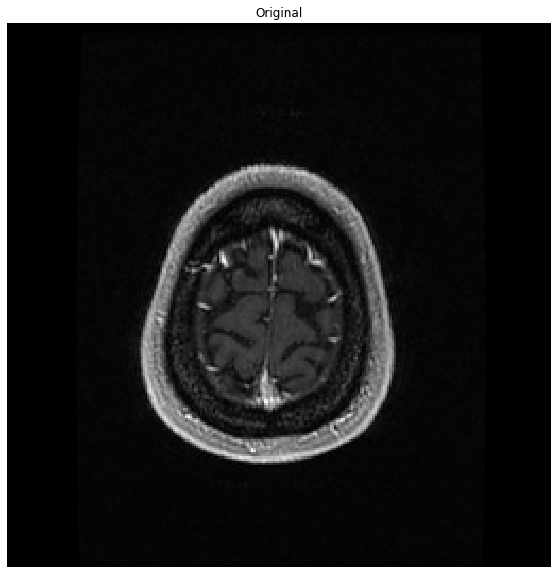

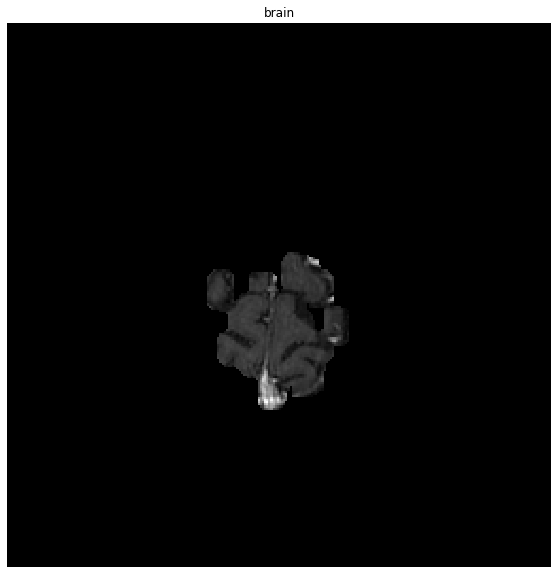

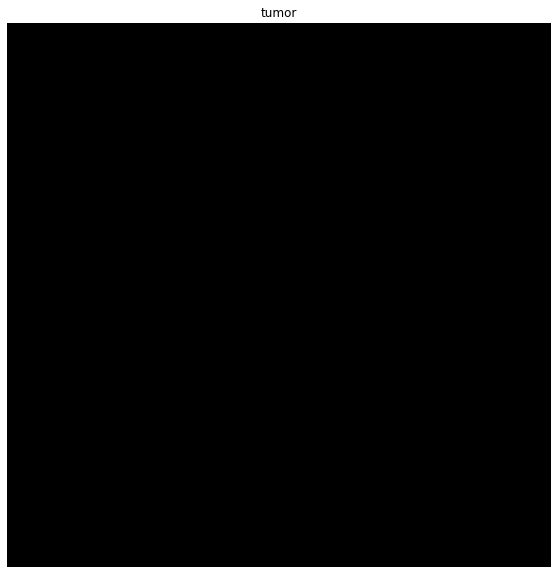

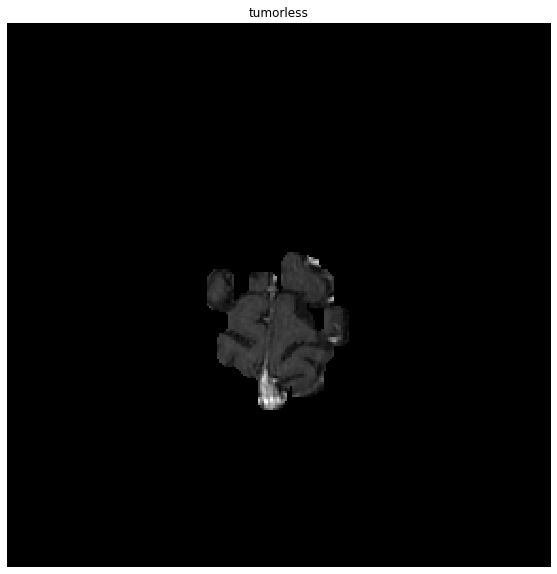

In [160]:
ds = pydicom.dcmread('original\IMG0095.dcm')

orig = ds.pixel_array
brain = CropIt(ds.pixel_array)
tumor = CropTumor(brain)
tumorless = CropTumorless(brain,tumor)

ShowImage("Original",orig,"gray")
ShowImage("brain",brain,"gray")
ShowImage("tumor",tumor,"gray")
ShowImage("tumorless",tumorless,"gray")

In [161]:
import os.path
InputPath = 'original'
TumorPath = 'tumor'
TumorlessPath = 'tumorless'
num_files = len([f for f in os.listdir(InputPath)
                if os.path.isfile(os.path.join(InputPath, f))])
print(num_files)
start = int(num_files*0.45)
end = int(num_files*0.85)
print(start,end)

112
50 95


In [162]:
if start<10 and end<10:
    flag=1
elif start<10 and end>10 and end<100:
    flag=2
elif start>10 and end<100:
    flag=3
else:
    flag=4
print(flag)

3


In [163]:
startTumor = 1
startTumorless = 1

max Valu :  93
0.076080322265625
50


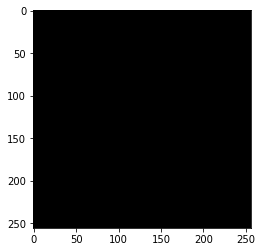

max Valu :  101
0.042633056640625
51


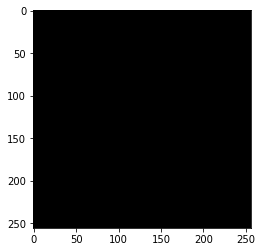

max Valu :  96
0.085052490234375
52


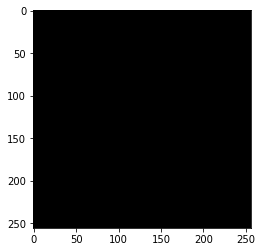

max Valu :  98
0.065338134765625
53


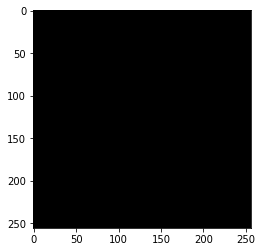

max Valu :  95
0.086669921875
54


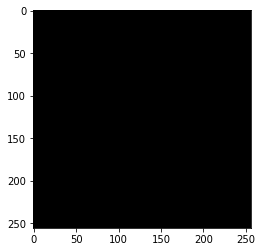

max Valu :  95
0.0816497802734375
55


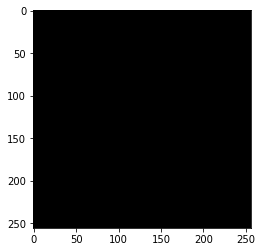

max Valu :  95
0.0865325927734375
56


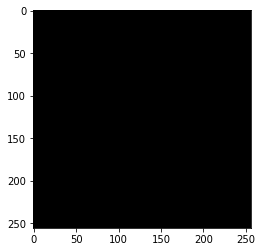

max Valu :  95
0.081024169921875
57


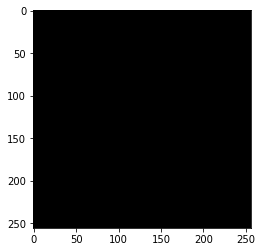

max Valu :  96
0.072357177734375
58


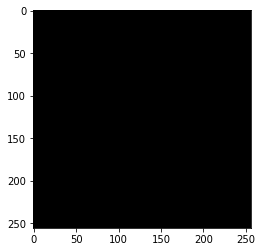

max Valu :  94
0.0913543701171875
59


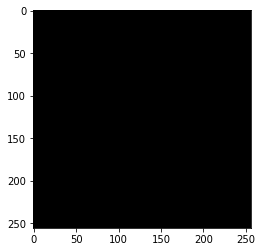

max Valu :  101
0.0341033935546875
60


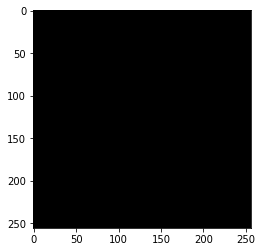

max Valu :  94
0.0747833251953125
61


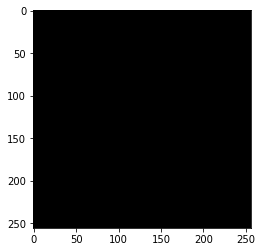

max Valu :  93
0.0748748779296875
62


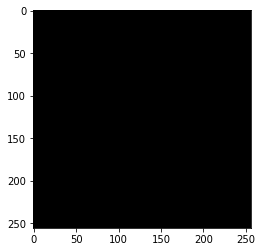

max Valu :  92
0.0833282470703125
63


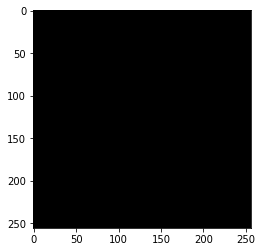

max Valu :  91
0.0858612060546875
64


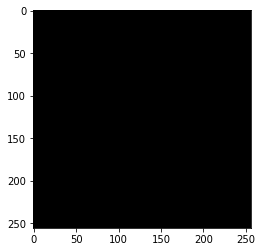

max Valu :  96
0.05224609375
65


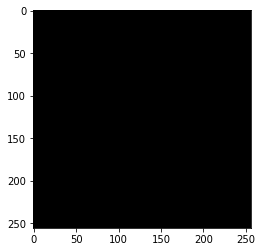

max Valu :  153
0.002960205078125
153
66


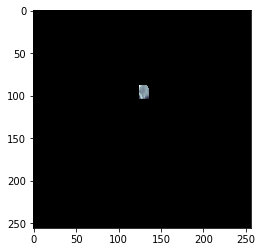

max Valu :  148
0.005096435546875
148
67


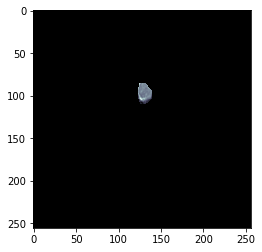

max Valu :  153
0.006561279296875
153
68


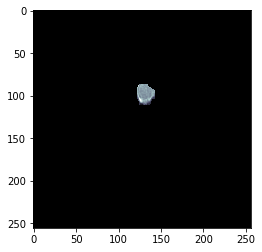

max Valu :  148
0.0082550048828125
148
69


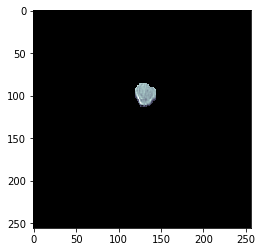

max Valu :  155
0.0094451904296875
155
70


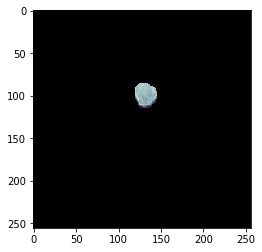

max Valu :  157
0.0103912353515625
157
71


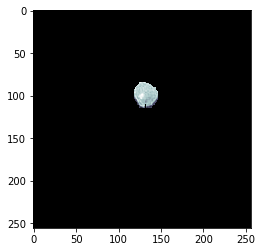

max Valu :  159
0.01123046875
159
72


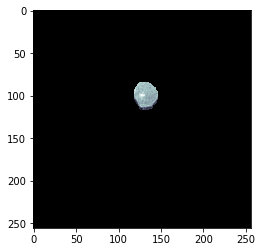

max Valu :  158
0.011688232421875
158
73


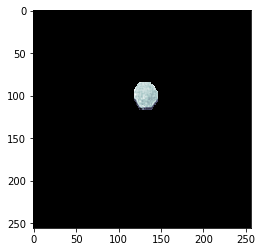

max Valu :  159
0.0121002197265625
159
74


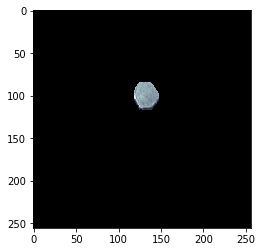

max Valu :  158
0.0120086669921875
158
75


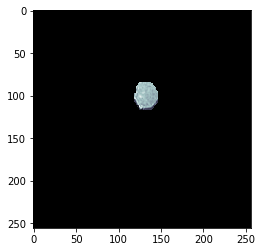

max Valu :  158
0.0120697021484375
158
76


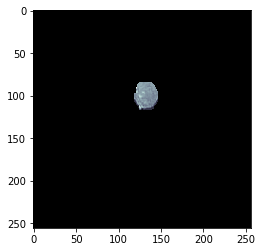

max Valu :  159
0.0121612548828125
159
77


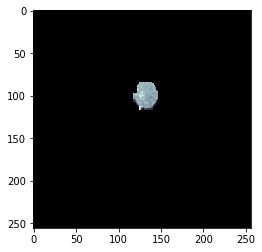

max Valu :  160
0.012054443359375
160
78


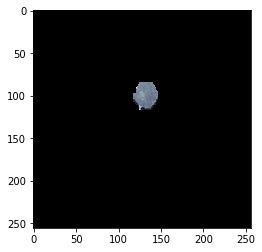

max Valu :  160
0.0117340087890625
160
79


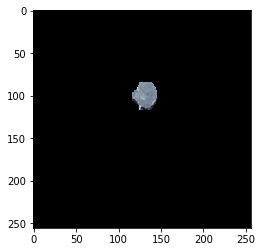

max Valu :  158
0.010833740234375
158
80


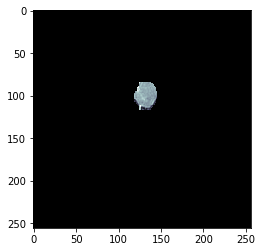

max Valu :  158
0.0099334716796875
158
81


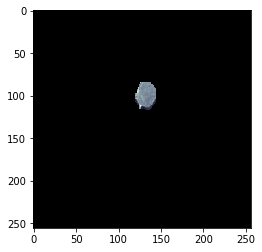

max Valu :  153
0.0090789794921875
153
82


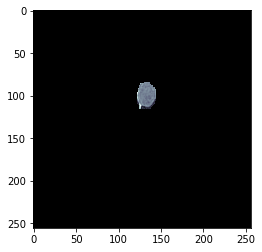

max Valu :  156
0.008209228515625
156
83


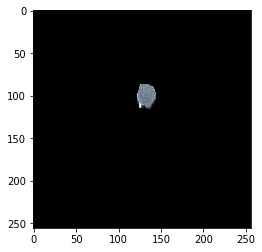

max Valu :  157
0.006988525390625
157
84


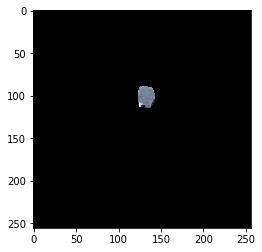

max Valu :  154
0.0062255859375
154
85


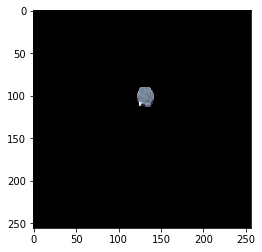

max Valu :  152
0.0048980712890625
152
86


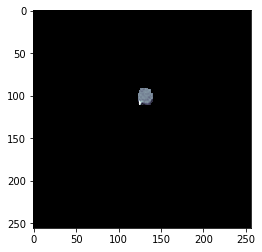

max Valu :  153
0.0034027099609375
153
87


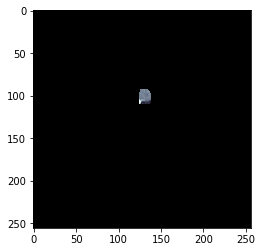

max Valu :  144
0.0025482177734375
144
88


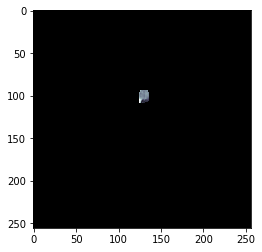

max Valu :  107
0.0026092529296875
89


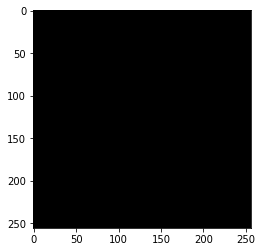

max Valu :  71
0.0498809814453125
90


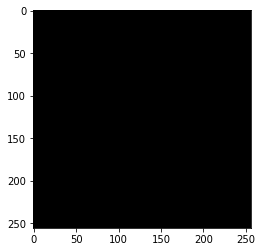

max Valu :  72
0.0353240966796875
91


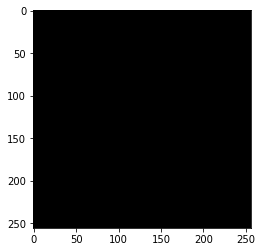

max Valu :  127
0.0017242431640625
92


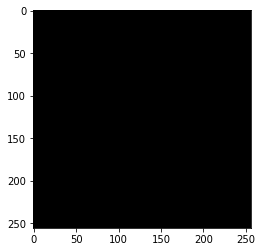

max Valu :  74
0.02593994140625
93


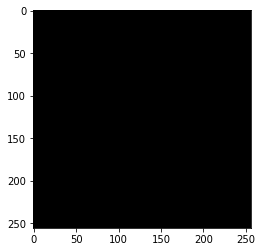

max Valu :  127
0.002044677734375
94


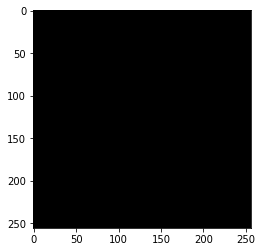

In [164]:
if flag==1:
    for i in range(start,end):
        ds = pydicom.dcmread(InputPath+'\IMG000'+str(i)+'.dcm')
        dicomImage = ds.pixel_array
        
        brain = np.zeros(dicomImage.shape)
        brain = CropIt(dicomImage)
        ds.pixel_array.flat=brain.flat
        ds.PixelData = ds.pixel_array.tobytes()
        ds.save_as("Brain\IMG000"+str(i)+".dcm")
        
        tumor = np.zeros(dicomImage.shape)
        tumor = CropTumor(dicomImage)
        ds.pixel_array.flat=tumor.flat
        ds.PixelData = ds.pixel_array.tobytes()
        ds.save_as(TumorPath+"\IMG000"+str(startTumor)+".dcm")
        startTumor = startTumor+1
        
        tumorless = np.zeros(dicomImage.shape)
        tumorless = CropTumorless(brain,tumor)
        ds.pixel_array.flat=tumorless.flat
        ds.PixelData = ds.pixel_array.tobytes()
        ds.save_as(TumorlessPath+"\IMG000"+str(startTumorless)+".dcm")
        startTumorless = startTumorless+1
        
        print(i)
        plt.imshow(tumorless, cmap=plt.cm.bone)
        plt.show()
elif flag==2:
    for i in range(start,9):
        ds = pydicom.dcmread(InputPath+'\IMG000'+str(i)+'.dcm')
        dicomImage = ds.pixel_array
        
        brain = np.zeros(dicomImage.shape)
        brain = CropIt(dicomImage)
        ds.pixel_array.flat=brain.flat
        ds.PixelData = ds.pixel_array.tobytes()
        ds.save_as("Brain\IMG000"+str(i)+".dcm")
        
        tumor = np.zeros(dicomImage.shape)
        tumor = CropTumor(dicomImage)
        ds.pixel_array.flat=tumor.flat
        ds.PixelData = ds.pixel_array.tobytes()
        ds.save_as(TumorPath+"\IMG000"+str(startTumor)+".dcm")
        startTumor = startTumor+1
        
        tumorless = np.zeros(dicomImage.shape)
        tumorless = CropTumorless(brain,tumor)
        ds.pixel_array.flat=tumorless.flat
        ds.PixelData = ds.pixel_array.tobytes()
        ds.save_as(TumorlessPath+"\IMG000"+str(startTumorless)+".dcm")
        startTumorless = startTumorless+1
        
        print(i)
        plt.imshow(brain, cmap=plt.cm.bone)
        plt.show()
    for i in range(10,end):
        ds = pydicom.dcmread(InputPath+'\IMG00'+str(i)+'.dcm')
        dicomImage = ds.pixel_array
        
        
        brain = np.zeros(dicomImage.shape)
        brain = CropIt(dicomImage)
        ds.pixel_array.flat=brain.flat
        ds.PixelData = ds.pixel_array.tobytes()
        ds.save_as("Brain\IMG000"+str(i)+".dcm")
        
        tumor = np.zeros(dicomImage.shape)
        tumor = CropTumor(dicomImage)
        ds.pixel_array.flat=tumor.flat
        ds.PixelData = ds.pixel_array.tobytes()
        ds.save_as(TumorPath+"\IMG000"+str(startTumor)+".dcm")
        startTumor = startTumor+1
        
        tumorless = np.zeros(dicomImage.shape)
        tumorless = CropTumorless(brain,tumor)
        ds.pixel_array.flat=tumorless.flat
        ds.PixelData = ds.pixel_array.tobytes()
        ds.save_as(TumorlessPath+"\IMG000"+str(startTumorless)+".dcm")
        startTumorless = startTumorless+1
        
        print(i)
        plt.imshow(brain, cmap=plt.cm.bone)
        plt.show()
elif flag==3:
    for i in range(start,end):
        ds = pydicom.dcmread('original\IMG00'+str(i)+'.dcm')
        dicomImage = ds.pixel_array
        
        
        brain = np.zeros(dicomImage.shape)
        brain = CropIt(dicomImage)
        ds.pixel_array.flat=brain.flat
        ds.PixelData = ds.pixel_array.tobytes()
        ds.save_as("Brain\IMG000"+str(i)+".dcm")
        
        tumor = np.zeros(dicomImage.shape)
        tumor = CropTumor(dicomImage)
        ds.pixel_array.flat=tumor.flat
        ds.PixelData = ds.pixel_array.tobytes()
        ds.save_as(TumorPath+"\IMG000"+str(startTumor)+".dcm")
        startTumor = startTumor+1
        
        tumorless = np.zeros(dicomImage.shape)
        tumorless = CropTumorless(brain,tumor)
        ds.pixel_array.flat=tumorless.flat
        ds.PixelData = ds.pixel_array.tobytes()
        ds.save_as(TumorlessPath+"\IMG000"+str(startTumorless)+".dcm")
        startTumorless = startTumorless+1
        
        print(i)
        plt.imshow(tumor, cmap=plt.cm.bone)
        plt.show()
else:
    for i in range(start,9):   
        ds = pydicom.dcmread(InputPath+'\IMG000'+str(i)+'.dcm')
        dicomImage = ds.pixel_array
        
        
        brain = np.zeros(dicomImage.shape)
        brain = CropIt(dicomImage)
        ds.pixel_array.flat=brain.flat
        ds.PixelData = ds.pixel_array.tobytes()
        
        tumor = np.zeros(dicomImage.shape)
        tumor = CropTumor(dicomImage)
        ds.pixel_array.flat=tumor.flat
        ds.PixelData = ds.pixel_array.tobytes()
        ds.save_as(TumorPath+"\IMG000"+str(startTumor)+".dcm")
        startTumor = startTumor+1
        
        tumorless = np.zeros(dicomImage.shape)
        tumorless = CropTumorless(brain,tumor)
        ds.pixel_array.flat=tumorless.flat
        ds.PixelData = ds.pixel_array.tobytes()
        ds.save_as(TumorlessPath+"\IMG000"+str(startTumorless)+".dcm")
        startTumorless = startTumorless+1
        
        print(i)
        plt.imshow(tumorless, cmap=plt.cm.bone)
        plt.show()
    for i in range(10,99):   
        ds = pydicom.dcmread(InputPath+'\IMG00'+str(i)+'.dcm')
        dicomImage = ds.pixel_array
        
        
        brain = np.zeros(dicomImage.shape)
        brain = CropIt(dicomImage)
        ds.pixel_array.flat=brain.flat
        ds.PixelData = ds.pixel_array.tobytes()
        
        tumor = np.zeros(dicomImage.shape)
        tumor = CropTumor(dicomImage)
        ds.pixel_array.flat=tumor.flat
        ds.PixelData = ds.pixel_array.tobytes()
        ds.save_as(TumorPath+"\IMG000"+str(startTumor)+".dcm")
        startTumor = startTumor+1
        
        tumorless = np.zeros(dicomImage.shape)
        tumorless = CropTumorless(brain,tumor)
        ds.pixel_array.flat=tumorless.flat
        ds.PixelData = ds.pixel_array.tobytes()
        ds.save_as(TumorlessPath+"\IMG000"+str(startTumorless)+".dcm")
        startTumorless = startTumorless+1
        
        print(i)
        plt.imshow(tumorless, cmap=plt.cm.bone)
        plt.show()
        
    for i in range(100,end):   
        ds = pydicom.dcmread(InputPath+'\IMG0'+str(i)+'.dcm')
        dicomImage = ds.pixel_array
        
        
        brain = np.zeros(dicomImage.shape)
        brain = CropIt(dicomImage)
        ds.pixel_array.flat=brain.flat
        ds.PixelData = ds.pixel_array.tobytes()
        
        tumor = np.zeros(dicomImage.shape)
        tumor = CropTumor(dicomImage)
        ds.pixel_array.flat=tumor.flat
        ds.PixelData = ds.pixel_array.tobytes()
        ds.save_as(TumorPath+"\IMG000"+str(startTumor)+".dcm")
        startTumor = startTumor+1
        
        tumorless = np.zeros(dicomImage.shape)
        tumorless = CropTumorless(brain,tumor)
        ds.pixel_array.flat=tumorless.flat
        ds.PixelData = ds.pixel_array.tobytes()
        ds.save_as(TumorlessPath+"\IMG000"+str(startTumorless)+".dcm")
        startTumorless = startTumorless+1
        
        print(i)
        plt.imshow(tumorless, cmap=plt.cm.bone)
        plt.show()